# TRPO & PPO

## TRPO算法

***策略梯度算法主要沿着J(θ)方向迭代更新策略参数θ 。但是这种算法有一个明显的缺点：当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。***

TRPO算法:考虑在更新时找到一块信任区域,在这个区域上更新策略时能够得到某种策略性能的安全性保证，这就是**信任区域策略优化**

### 细节上

#### 1.确定策略目标

如何有效推动策略进步?
- 通过计算新旧策略之间的差异

![JJ](./pic/JJ.png)

+ 得到新旧策略之间的区别后，如何优化目标策略求解方法，使得该问题**可解**

+ 因为π_是我们需要求解的策略，但我们又要用它来收集样本。把所有可能的新策略都拿来收集数据，然后判断哪个策略满足上述条件的做法显然是不现实的。
---
+ 对状态访问分布作近似，具体而言，忽略两个策略之间的状态访问分布变化，直接采用旧的策略的状态分布π，定义如下替代优化目标：（问题是：使用旧的策略分布导致，在算法中认为新旧策略的占用度量相同，也就是说两个策略是一样的。如何处理这个问题呢？？？）

+ 答：当新旧策略非常接近时，状态访问分布变化很小，这么近似是合理的。其中，动作仍然用新策略π_采样得到，我们可以用重要性采样对动作分布进行处理：
---
+ 为了保证新旧策略足够接近，TRPO 使用了库尔贝克-莱布勒（Kullback-Leibler，KL）散度来衡量策略之间的距离，并给出了整体的优化公式：

![KL](./pic/KL.png)

#### 2.利用泰勒展开近似

为什么能用一阶和二阶近似？

答：这是牛顿法优化思路，在泰勒展开项中，目标函数的0阶是没有信息的（=0），约束函数的1阶和0阶同理。
另：
目标函数的一阶近似： 目标函数是希望最大化的奖励期望。在 TRPO 中，为了简化求解过程，使用一阶泰勒展开来近似目标函数。***这样的近似下，目标函数就变成了一个线性函数，可以用线性优化方法进行优化。***

约束的二阶近似： 约束是策略变化的界限，用于确保新策略不会过于偏离当前策略。这个约束通常用 KL 散度来度量。在 TRPO 中，使用二阶泰勒展开来近似这个约束。这样的近似下，约束就变成了一个二次函数，可以用二次规划的方法进行求解

优化目标：

![TC](./pic/TaC.png)

![KKT](./pic/KKT.png)

![KKTTar](./pic/KKTTar.png)

#### 3.共轭梯度简化更新方向

**为什么用共轭梯度法不用牛顿法**：牛顿法求解Hessian矩阵的逆，计算量过大。

关于共轭梯度的详细理解见：http://hliangzhao.me/math/CG.pdf

TRPO 通过共轭梯度法（conjugate gradient method）计算更新方向和步长

直接计算$x=H^{-1}g$，$Hx=g$

$x$是参数更新的方向

假设满足 KL 距离约束的参数更新时的最大步长为β
根据 KL 距离约束条件，有

![beta](./pic/beta.png)

![Dist](./pic/Dist.png)

![Update](./pic/Update.png)

共轭梯度的具体流程如下：

![CG](./pic/CG.png)

在共轭梯度运算过程中，直接计算$\alpha_k$和$r_{K+1}$需要计算和存储海森矩阵$H$。为了避免这种大矩阵的出现，我们只计算向量$Hx$，而不直接计算和存储矩阵。

#### 4.线性搜索确保解满足条件

由于 TRPO 算法用到了泰勒展开的 1 阶和 2 阶近似，这并非精准求解，因此，θ`可能未必比好θ，或未必能满足 KL 散度限制。

因此，TRPO 在每次迭代的最后进行一次线性搜索：具体来说，就是找到一个最小的非负整数i，使得按照

![LS](./pic/LS.png)

**TRPO算法大致过程：**

![TRPO](./pic/TRPO.png)

#### 广义优势估计

利用指数加权平均的方法：对差分优势的步数做超参数筛选。

1.多步时序差分优势函数

![MTD](./pic/MTD.png)

2.将不同步数的优势估计进行指数加权平均

![GAE](./pic/GAE.png)

当λ=0时，$Α_t^{GAE}=σ_t$，也即是仅仅只看一步差分得到的优势；当λ=1时，$Α_t^{GAE}=\Sigma_{l=0}^n γ^lσ_{t+1}$，则是看每一步差分得到优势的完全平均值。

***
详见[1] SCHULMAN J, LEVINE S, ABBEEL P, et al. Trust region policy optimization [C]// International conference on machine learning, PMLR, 2015:1889-1897.
***


In [ ]:
'''
torch.detach（）的用法
'''
import torch

a = torch.tensor([1.0,2.0,3.0],requires_grad = True)

print(a.grad)
out = a.sigmoid()
print(out)

c = out.detach()
print(c)
#对detach后的修改会该原始的tensor
print(c.zero_())

print(out)
#不能对原始tensor 修改
# out.zero_().backward() 报错

In [1]:
#GAE 的代码
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list,dtype = torch.float)

In [2]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [11]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, act_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, act_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x),dim =1)
        
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
class TRPO:
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device
        
    def take_action(self, state):
        state = torch.tensor([state], dtype = torch.float).to(self.device)
        probs = self.actor(state)
        #按照probs的概率进行采样
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        #计算Hx
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists)
        )
        
        kl_grad = torch.autograd.grad(kl,self.actor.parameters(),create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector
    
    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x
    
    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para
    
    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|████████████| 50/50 [00:10<00:00,  4.70it/s, episode=500, return=149.000]


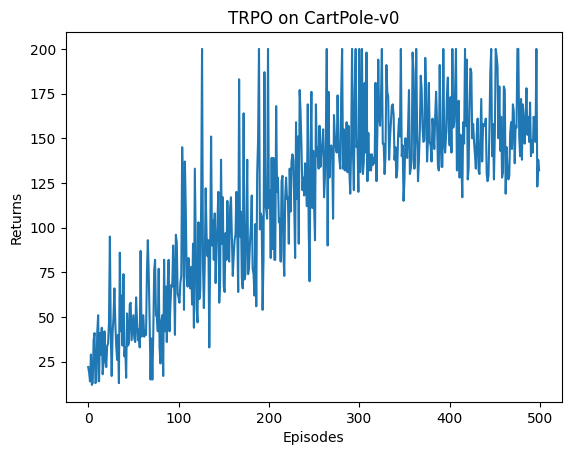

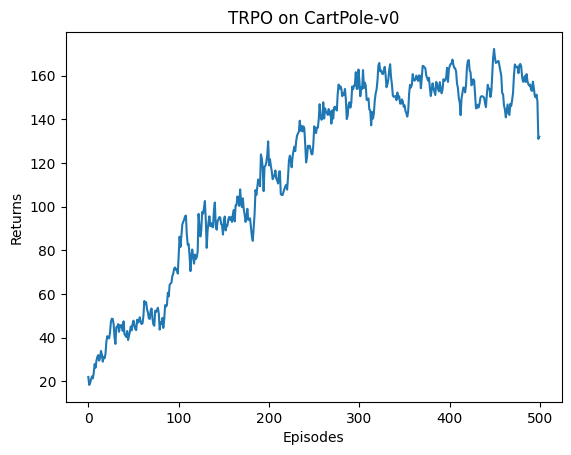

In [12]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

## PPO算法
TRPO 算法在很多场景上的应用都很成功，但是我们也发现它的计算过程非常复杂，每一步更新的运算量非常大。于是，TRPO 算法的改进版——PPO 算法\
二者的优化目标是一样的
![TRPOTarget](./pic/TRPOTarget.png)
### 区别的
#### PPO-Penalty
用拉格朗日乘数法直接将KL散度的约束放在目标函数中
![PPOP](./pic/PPOP.png)
在迭代过程中不断更新$β$
$d_k=D_{KL}^{υ^{π_{θ_k}}}(π_{θ_k},π_{θ})$
if $d_k<δ/1.5$
    $β_{k+1}=β_{k}/2$
elif $d_k>δ*1.5$
    $β_{k+1}=β_{k}*2$
else
    $β_{k+1}=β_{k}$
$δ$是一个超参数，用于限制学习策略和之前一轮策略的差距。

#### PPO-Clip
截断（PPO-Clip）更加直接，它在目标函数中进行限制，以保证新的参数和旧的参数的差距不会太大。
![PPOC](./pic/PPOC.png)

![PPOC2](./pic/PPOC2.png)


In [13]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [14]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|████████████| 50/50 [00:12<00:00,  4.13it/s, episode=500, return=200.000]


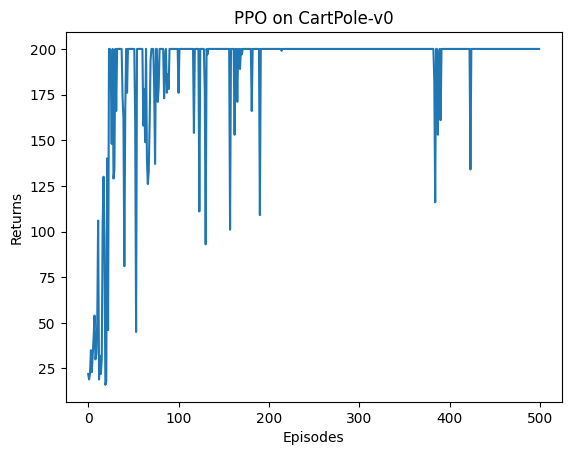

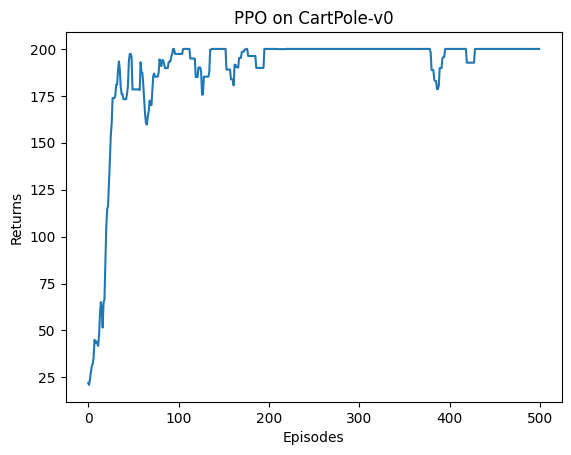

In [15]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()